<center><h1> Multi Subject Dictionnary Learning to segment Atlas of Brain <h1><center>

<h2><u>1- Generation of synthetic data</u><h2>

In [23]:
from utils import *
from blob import *

<h3><u>a- Group level latent spatial map</u><h3>

<span style="font-size: 15px;"> 
We first create group levels latent maps using a blob model: <br>  

- Each map is made of "a few cones-shaped localized patterns the position and size of which are chosen randomly". <br>    
- The number of blobs on each map follows a binomial distribution of parameters (3,0.5).  <br>
- We generate maps one after the other and we avoid overlapping between blob centers across the maps.  <br>
</span>


In [32]:
def create_latent_maps(grid_length: int = 50, k:int = 5):
    latent_global_maps = []
    centers_to_avoid = []
    all_blobs = [] #list of lists, each containing the blobs of a latent map
    for numMap in range(k):
        # generate random blobs and add the new centers to avoid in the list for the next round
        blobs, centers_to_avoid = get_random_blobs(grid_length, max_blobs=3, centers_to_avoid=centers_to_avoid)
        # create latent maps from the generated latent maps 
        latent_global_maps.append(generate_global_map(grid_length, blobs = blobs))
        # store the given blobs 
        all_blobs.append(blobs)
    latent_global_maps = np.array(latent_global_maps)
    return latent_global_maps, all_blobs

In [44]:
grid_length = 50 # we create a map of (50,50)
k = 5 # we create 5 latent maps
latent_global_maps = create_latent_maps(grid_length=50, k =5) # we create 5 goup level latent maps 

/var/folders/h1/60s3lm216j19z_94ccr7mdbh0000gn/T/ipykernel_37225/2298126617.py:6: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


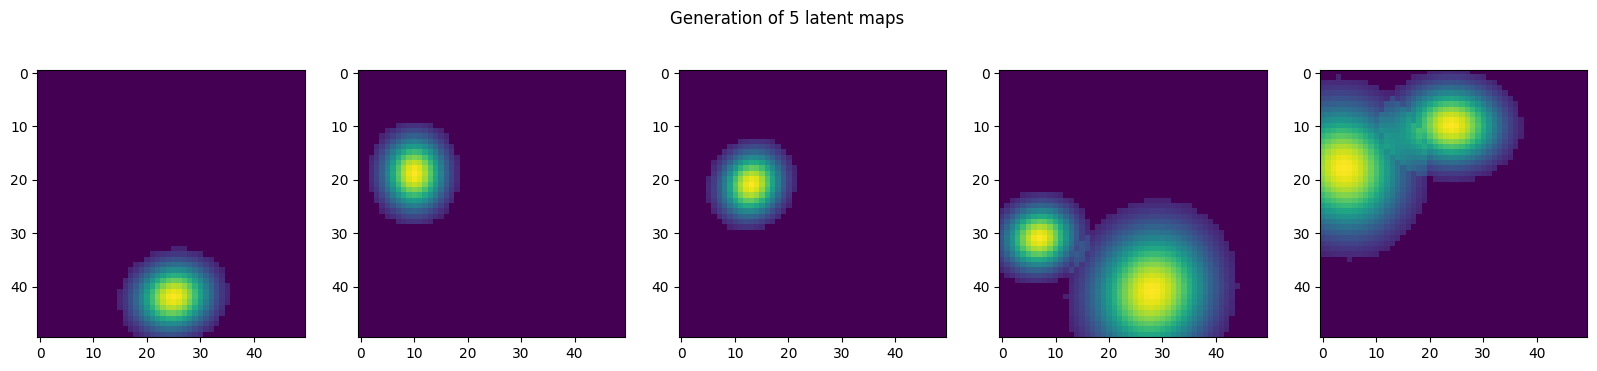

In [43]:
latent_global_maps, all_blobs = create_latent_maps(grid_length=50, k =5)
fig, ax = plt.subplots(1,k, figsize=(20, 4))
fig.suptitle('Generation of 5 latent maps')
for i in range(k):
    ax[i].imshow(latent_global_maps[i, :,:])
fig.show()

<h3><u>b- Subject level latent spatial map</u><h3>

In [ ]:
def get_subject_blobs(all_blobs:List[List[Blob]], jitter=0, smoothness=0):
    """ 
    Returns the all_blobs list for one specific subject given the all_blobs GLOBAL list. 
    
    """
    all_subject_blobs = []
    for blob_list in all_blobs: #iterates over k the number of latent maps

        subject_blob_list = []
        for blob in blob_list: #iterates over the blobs of one specific latent map
            subject_blob = blob.get_copy() #avoid to lose info

            #add noise on both position and size of the blobs
            noise_on_width = np.random.normal(loc=0, scale=smoothness)
            if np.abs(noise_on_width) < blob.radius: #check that we don't have blob with negative radius
                subject_blob.radius += noise_on_width

            center_shift = np.random.normal(loc=0, scale=jitter, size=2).astype('int')
            
            #avoid losing blobs in the nature
            for coord in range(2):
                new_center_1d = center_shift[coord] + subject_blob.center[coord]
                nIt = 0
                while new_center_1d < 0 or new_center_1d > subject_blob.grid_length:
                    center_shift[coord] = int(center_shift[coord]/2 )
                    print(center_shift)
                    nIt +=1
                    if nIt == 3: break
            print("hello")
            subject_blob.center += center_shift

            subject_blob_list.append(subject_blob)

        all_subject_blobs.append(subject_blob_list)

    return all_subject_blobs


In [52]:
from typing import List

def get_subject_blobs(all_blobs: List[List['Blob']], jitter: float = 0, smoothness: float = 0) -> List[List['Blob']]:
    """ 
    Modifies and returns a list of blob lists, representing subject-specific blobs
    based on global blob characteristics, applying jitter and smoothness adjustments.
    
    Args:
    - all_blobs: A list of lists containing Blob objects.
    - jitter: The standard deviation of the normal distribution for center jitter.
    - smoothness: The standard deviation of the normal distribution for blob radius adjustment.
    
    Returns:
    - A list of lists containing adjusted Blob objects for a specific subject.
    """
    all_subject_blobs = []

    for blob_list in all_blobs:  # Iterates over each list of blobs corresponding to a latent map
        subject_blob_list = []

        for blob in blob_list:  # Iterates over individual blobs within a latent map
            subject_blob = blob.get_copy()  # Create a copy to avoid modifying the original blob

            # Apply noise to the blob's radius for smoothness effect
            noise_on_width = np.random.normal(loc=0, scale=smoothness)
            subject_blob.radius = max(subject_blob.radius + noise_on_width, 0)  # Ensure non-negative radius
            print(subject_blob.radius)

            # Apply jitter to the blob's center
            center_shift = np.random.normal(loc=0, scale=jitter, size=2).astype(int)
            
            # Ensure the blob's center remains within the grid boundaries
            subject_blob.center = np.clip(subject_blob.center + center_shift, 0, subject_blob.grid_length)
            print(subject_blob.center)

            subject_blob_list.append(subject_blob)

        all_subject_blobs.append(subject_blob_list)

    return all_subject_blobs


In [53]:
all_subject_blobs = get_subject_blobs(all_blobs, jitter=6, smoothness=2)


11.123134145414438
[32 10]
9.286202184312426
[33 31]
6.525187408038102
[50 18]
10.96997755557606
[ 6 16]
2.9911292862627623
[16 22]
6.481241592203963
[36 32]
10.969388158089142
[32 17]
7.41714003461998
[18 10]
9.317032852122384
[47 25]
6.302662140095232
[25 44]
5.3167446094383894
[36 31]


In [ ]:
def get_maps_from_all_blobs(all_blobs):
    """
    Made to generate latent SUBJECT maps mostly
    """
    latent_subject_maps = []
    for numMap in range(k):
        latent_subject_maps.append(generate_global_map(grid_length=50, blobs=all_blobs[numMap]))
    latent_subject_maps = np.array(latent_subject_maps)
    
    return latent_subject_maps

In [ ]:
latent_subject_maps = get_maps_from_all_blobs(all_subject_blobs)
latent_subject_maps.shape

In [ ]:
nbSubjects = 4
def create_subjects_latent_maps(nbSubjects)
    maps_from_subjects = []
    for num_subject in range(nbSubjects):
        all_subject_blobs = get_subject_blobs(all_blobs, jitter=6, smoothness=2)
        latent_subject_maps = get_maps_from_all_blobs(all_subject_blobs)
        maps_from_subjects.append(latent_subject_maps)
    return maps_from_subjects

In [ ]:
fig, ax = plt.subplots(k, figsize=(10, 20))
for i in range(k):
    ax[i].imshow(latent_subject_maps[i, :,:])
fig.show()

<h3><u>c- Generation of synthetic fmri data </u><h3>

In [ ]:
def generate_synthetic_fmri_data(nbSubjects, n, maps_per_subject:List[np.array], grid_length=50):
    """Generate synthetic fMRI data for multiple subjects."""
    data = np.zeros((nbSubjects, n, grid_length**2))

    for subject_idx in range(nbSubjects):
        subject_latent_maps = maps_per_subject[subject_idx] #of shape (k, grid_length, grid_length)
        k, _, _ = subject_latent_maps.shape
        subject_latent_vector = subject_latent_maps.reshape(k, grid_length**2) #careful: V_S.T in the article
        U_s = np.random.normal(loc=0, scale=2, size=(n, k))

        spatial_noise = get_random_spatially_correlated_noise(grid_length=grid_length, sigma=0.5, correlation_scale=0.5).reshape(grid_length**2)
        observations = U_s @ subject_latent_vector + spatial_noise
        data[subject_idx] = observations

    return data.reshape(nbSubjects, n, grid_length, grid_length)

In [ ]:
# Parameters
time_points = 150
grid_size = 50

# Generate synthetic fMRI data
synthetic_data = generate_synthetic_fmri_data(nbSubjects, time_points, maps_from_subjects)

In [ ]:
synthetic_data.shape

In [ ]:
np.save("synthetic_data", synthetic_data)


In [ ]:
plt.imshow(maps_from_subjects[0][3, :, :])

In [ ]:
# Visualize one of the generated maps
plt.imshow(synthetic_data[0, 3, :, : ], cmap='gray')

plt.title("Sample Synthetic fMRI Map")
plt.colorbar()
plt.show()

In [ ]:
grid_length = 50
noise = get_random_spatially_correlated_noise(grid_length=grid_length, correlation_scale=0.5)
plt.contourf(np.arange(grid_length), np.arange(grid_length), noise)
plt.colorbar()

In [ ]:
plt.imshow(noise)
plt.colorbar()

In [ ]:
plt.imshow(generate_correlated_noise(50))